In [43]:
import pandas as pd
import os
import numpy as np
import tarfile
import numpy as np
import re

import string
import tensorflow as tf
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd "drive/MyDrive/UQ/DECO3801"

/content/drive/MyDrive/UQ/DECO3801


In [ ]:
# Allow GPU memory growth
#physical_devices = tf.config.list_physical_devices('GPU')
#if len(physical_devices) > 0:
#    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Next word prediction task: I'm trying to build the BiLSTM model to predict the next word from an incomplete sentence to help people with disability feel easier to interact with computer via AUSLAN.

https://www.idiap.ch/en/dataset/ted

In [28]:
ted = pd.read_csv("transcripts.csv")

In [29]:
ted['transcript'][0]

'Good morning. How are you?(Laughter)It\'s been great, hasn\'t it? I\'ve been blown away by the whole thing. In fact, I\'m leaving.(Laughter)There have been three themes running through the conference which are relevant to what I want to talk about. One is the extraordinary evidence of human creativity in all of the presentations that we\'ve had and in all of the people here. Just the variety of it and the range of it. The second is that it\'s put us in a place where we have no idea what\'s going to happen, in terms of the future. No idea how this may play out.I have an interest in education. Actually, what I find is everybody has an interest in education. Don\'t you? I find this very interesting. If you\'re at a dinner party, and you say you work in education — Actually, you\'re not often at dinner parties, frankly.(Laughter)If you work in education, you\'re not asked.(Laughter)And you\'re never asked back, curiously. That\'s strange to me. But if you are, and you say to somebody, you

In [30]:
data = ted['transcript'].apply(lambda x: x.lower())

In [ ]:
type(data)

pandas.core.series.Series

In [ ]:
data

0       good morning. how are you?(laughter)it's been ...
1       thank you so much, chris. and it's truly a gre...
2       (music: "the sound of silence," simon & garfun...
3       if you're here today — and i'm very happy that...
4       about 10 years ago, i took on the task to teac...
                              ...                        
2462    so, ma was trying to explain something to me a...
2463    this is a picture of a sunset on mars taken by...
2464    in my early days as a graduate student, i went...
2465    i took a cell phone and accidentally made myse...
2466    we humans are becoming an urban species, so ci...
Name: transcript, Length: 2467, dtype: object

In [31]:
# I have to cut a lot of data because of out of ram when processing.
data = data[:20]

In [32]:
def clean_data(text):
    # Format words and remove unwanted characters
    text = re.sub(r'&amp;', '', text)
    text = re.sub(r'[_"\-;%()|+&=*%:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'br', ' ', text)
    text = re.sub(r'\'', '', text)
    return text

In [10]:
def clean_text(text):
  tokens = text.split()
  table = str.maketrans('','', string.punctuation)
  tokens = [w.translate(table) for w in tokens]
  tokens = [word for word in tokens if word.isalpha()]
  tokens = [word.lower() for word in tokens]
  return tokens

In [33]:
data = data.apply(clean_data)

#NEW

In [34]:
# Assuming 'data' is your pandas Series
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data)
total_words = len(tokenizer.word_index) + 1

input_sequences = []
for line in data:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

max_sequence_length = max([len(seq) for seq in input_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='pre')


In [35]:
X = input_sequences[:, :-1]
y = input_sequences[:, -1]

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
model = Sequential()
model.add(Embedding(input_dim=total_words, output_dim=100, input_length=max_sequence_length - 1))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(100, activation='relu'))
model.add(Dense(total_words, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 4322, 100)         616400    
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 100)               25700     
                                                                 
 dense_2 (Dense)             (None, 6164)              622564    
                                                                 
Total params: 1,499,160
Trainable params: 1,499,160
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [39]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, verbose=1,
                    validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50
1506/1506 [==============================] - 550s 363ms/step - loss: 6.5887 - accuracy: 0.0460 - val_loss: 6.4333 - val_accuracy: 0.0524
Epoch 2/50
1506/1506 [==============================] - 430s 286ms/step - loss: 6.1781 - accuracy: 0.0664 - val_loss: 6.3151 - val_accuracy: 0.0777
Epoch 3/50
1506/1506 [==============================] - 405s 269ms/step - loss: 5.8958 - accuracy: 0.0885 - val_loss: 6.2624 - val_accuracy: 0.0914
Epoch 4/50
1506/1506 [==============================] - 392s 260ms/step - loss: 5.6591 - accuracy: 0.1055 - val_loss: 6.2690 - val_accuracy: 0.1024
Epoch 5/50
1506/1506 [==============================] - 384s 255ms/step - loss: 5.4476 - accuracy: 0.1195 - val_loss: 6.2576 - val_accuracy: 0.1081
Epoch 6/50
1506/1506 [==============================] - 384s 255ms/step - loss: 5.2515 - accuracy: 0.1307 - val_loss: 6.4275 - val_accuracy: 0.1118
Epoch 7/50
1506/1506 [==============================] - 381s 253ms/step - loss: 5.0598 - accuracy: 0.1420 - val_

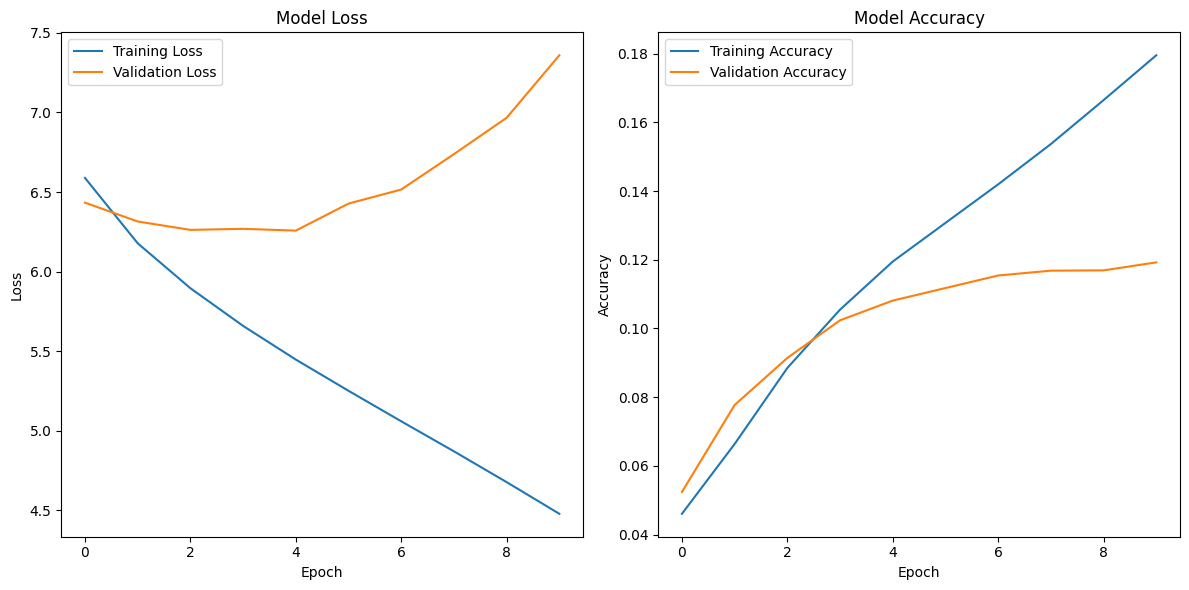

In [44]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [57]:
seed_text = "We recommend avoiding posting privately so that"
next_words = 3

for _ in range(next_words):
    # tokenizer
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    # padding
    token_list = pad_sequences([token_list], maxlen=max_sequence_length - 1, padding='pre')
    predicted_probs = model.predict(token_list)[0]
    # take the word's index with highest probability
    predicted_index = np.argmax(predicted_probs)

    # find word based on that index
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted_index:
            output_word = word
            break
    seed_text += " " + output_word

print(seed_text)

1/1 [==============================] - 0s 92ms/step
We recommend avoiding posting privately so that i have a


In [41]:
model.save('nextwordsbilstm.h5')

In [ ]:
# The model has very low accuracy currently

#Old code

In [ ]:
# Merge texts together
merge_data = ''.join(data)

In [ ]:
tokens = clean_text(merge_data)

In [ ]:
print(len(tokens))
print(len(set(tokens)))

14333
2926


In [ ]:
# using 50 set of previous words to predict the next word
length = 50 + 1
lines = []

for i in range(length, len(tokens)):
  seq = tokens[i - length:i]
  line = ' '.join(seq)
  lines.append(line)
  # take initiate 200000 words
  if i > 500000:
    break

print(len(lines))

14282


In [ ]:
# first 50 words
lines[0]

'good morning how are youlaughterits been great hasnt it ive been blown away by the whole thing in fact im leavinglaughterthere have been three themes running through the conference which are relevant to what i want to talk about one is the extraordinary evidence of human creativity in all of the'

In [ ]:
tokens[51]

'presentations'

In [ ]:
lines[1]

'morning how are youlaughterits been great hasnt it ive been blown away by the whole thing in fact im leavinglaughterthere have been three themes running through the conference which are relevant to what i want to talk about one is the extraordinary evidence of human creativity in all of the presentations'

Build BiLSTM

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)

In [ ]:
sequences = np.array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]

In [ ]:
X[0]

array([ 119,  737,   65,   16, 2922,  133,  408, 1174,   13,  159,  133,
       1172,  334,   55,    1,  191,  148,    6,  535,   52, 2921,   14,
        133,  258, 2919,  534,  406,    1,  533,   54,   16, 1171,    3,
         29,    8,   93,    3,  190,   31,   35,    9,    1,  736, 1170,
          4,  287,  404,    6,   23,    4])

In [ ]:
y[0]

1

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

6790


In [ ]:
y = to_categorical(y, num_classes=vocab_size)

In [ ]:
X.shape

(57683, 50)

In [ ]:
y.shape

(57683, 6790)

In [ ]:
seq_length = X.shape[1]

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=seq_length))
model.add(LSTM(256, return_sequences=True))  # Output sequences for each time step
model.add(Dense(128, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 50)            339500    
                                                                 
 lstm_3 (LSTM)               (None, 50, 256)           314368    
                                                                 
 dense_4 (Dense)             (None, 50, 128)           32896     
                                                                 
 dense_5 (Dense)             (None, 50, 6790)          875910    
                                                                 
Total params: 1,562,674
Trainable params: 1,562,674
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile the model with sparse categorical cross-entropy loss.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X, y, epochs=100, batch_size=16)

In [ ]:
model.save('nextwordlstm.h5')

Draft